In [1]:
from pygmo import hypervolume
import csv
import statistics
import numpy as np
import operator as op
from functools import reduce
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [2]:
#### Useful functions and parameter defintions
np.set_printoptions(threshold=np.inf)

# Create array of NFE values at which to compute hypervolume (assumes max function evaluations is 3000)
n_iter_total = 50 # Total number of points in NFE array (1 more than input value to incorporate 0)
n_iter_init = 40 # Number of initial points in NFE array separated by 50 (the rest after that are separated by 100)
nfe_array = np.zeros(n_iter_total+1)
for i in range(n_iter_init):
    nfe_array[i] = 50*i
    
for i in range(n_iter_total - n_iter_init + 1):
    nfe_array[n_iter_init+i] = 50*n_iter_init + 100*i

# NO LONGER USED AFTER TRUE OJECTIVES ARE READ FROM CSV FILES (NOW get_true_objectives is used)
#def compute_true_objectives(pen_obj1, pen_obj2, feas_score, stab_score, orient_score, fib_stiff, intpen_feas, intpen_stab, intpen_orient):
    #pen_fac = 1
    #if fib_stiff:
        #pen_fac = 1.5
    #if (intpen_feas and intpen_stab and (not intpen_orient)):
        #pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
    #elif (intpen_feas and (not intpen_stab) and (not intpen_orient)):
        #pen =  np.log10(np.absolute(feas_score))
    #elif ((not intpen_feas) and intpen_stab and (not intpen_orient)):
        #pen = np.log10(np.absolute(stab_score))
    #elif ((not intpen_feas) and (not intpen_stab) and intpen_orient):
        #pen = np.log10(np.absolute(orient_score))
    #elif ((not intpen_feas) and intpen_stab and intpen_orient):
        #pen = (np.log10(np.absolute(orient_score)) + np.log10(np.absolute(stab_score)))/2
    #elif (intpen_feas and (not intpen_stab) and intpen_orient):
        #pen = (np.log10(np.absolute(orient_score)) + np.log10(np.absolute(feas_score)))/2
    #elif (intpen_feas and intpen_stab and intpen_orient):
        #pen = (np.log10(np.absolute(orient_score)) + np.log10(np.absolute(feas_score)) + np.log10(np.absolute(orient_score)))/3
    #else:
        #pen = 0
    #obj1 = 5*(pen_obj1 + pen_fac*pen)
    #obj2 = -8500*(pen_obj2 + pen_fac*pen)
    #return obj1, obj2
    
def nchoosek(n,k):
    k = min(k, n-k)
    num = reduce(op.mul, range(n,n-k,-1), 1)
    den = reduce(op.mul, range(1,k+1), 1)
    return num/den    
    
def get_true_objectives(true_obj1_array, true_obj2_array, index):
    return true_obj1_array[index], true_obj2_array[index]

def get_feasibility_score(feas_array, index):
    return feas_array[index]

def get_connectivity_score(conn_array, index):
    return conn_array[index]

def get_stiffness_ratio(stiffrat_array, index):
    return stiffrat_array[index]

def get_partcoll_score(partcoll_array, index):
    return partcoll_array[index]

def get_nodprop_score(nodprop_array, index):
    return nodprop_array[index]

def get_orientation_score(orient_array, index):
    return orient_array[index]

def get_design(design_array, index):
    return design_array[index]

def find_last_index(val,search_list):
    if val in search_list:
        idx = len(search_list) - search_list[::-1].index(val) - 1
    else:
        idx = 0
    return idx

def find_closest_index(val,search_list):
    val_diff = np.array(search_list) - val
    closest_index = np.argmin(np.abs(val_diff))
    return closest_index

def compute_pareto_front(population):
    pop_size = len(population)
    obj_num = 2

    domination_counter = [0] * pop_size

    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # check each objective for dominance
            dominate = [0] * obj_num
            for k in range(obj_num):
                if population[i][k] > population[j][k]:
                    dominate[k] = 1
                elif population[i][k] < population[j][k]:
                    dominate[k] = -1
            if -1 not in dominate and 1 in dominate:
                domination_counter[i] += 1
            elif -1 in dominate and 1 not in dominate:
                domination_counter[j] += 1

    pareto_solutions = []
    for i in range(len(domination_counter)):
        if domination_counter[i] == 0:
            pareto_solutions.append(population[i])
    return pareto_solutions

def compute_hv(population):
    array_archs = np.zeros((len(population), 2))
    for i in range(len(population)):
        array_archs[i] = population[i]
    hv_object = hypervolume(array_archs)
    hv = hv_object.compute([1.1,1.1])/1.1**2
    return hv

In [3]:
#### Determine csv filepath from given case type
def get_csv_filepath(partcoll_constrained, nodprop_constrained, orient_constrained, fib_stiff, optim_problem2, read_constrad, repeat_case, feas_bools, run_number):
    # partcoll_constrained = [int_pen, AOS, bias_init, ACH] boolean array
    # nodprop_constrained = [int_pen, AOS, bias_init, ACH] boolean array
    # orient_constrained = [int_pen, AOS, bias_init, ACH] boolean array
    # optim_problem2 - boolean to signify reading of optimization problem 2 data
    # read_constrad - boolean to signify reading of constant radii or variable radii data
    # repeat_case - either '1x1' or '3x3' representing the data for 3x3 or 1x1 repeated unit cells case
    # feas_constrained = [bias_init, AOS] boolean array
    
    filepath = 'C:\\SEAK Lab\\SEAK Lab Github\\KD3M3\\Truss_AOS\\result\\'
    methods = ['Int Pen','AOS','Bias Init','ACH']
    if (partcoll_constrained[1] or nodprop_constrained[1] or orient_constrained[1]):
        filename = 'AOSMOEA_emoea_'
    else:
        filename = 'EpsilonMOEA_emoea_'
        
    if (repeat_case == '3x3'):
        filepath_repeatcase = 'Repeat 3x3\\'
    elif (repeat_case == '1x1'):
        filepath_repeatcase = 'Repeat 1x1\\'
            
    
    if optim_problem2:
        filepath_prob = 'Opt Prob 2\\'
        if read_constrad:
            filename_prob = '_prob2'
        else:
            filename_prob = ''
    else:
        filepath_prob = 'Opt Prob 1\\'
        filename_prob = ''
        
    if read_constrad:
        filepath_constrad = 'Constant Radii\\'
    else:
        filepath_constrad = 'Variable Radii\\'
            
    
    filepath2 = ''
    filename2 = ''
    constr_count = 0
    for i in range(4):
        if(partcoll_constrained[i] and nodprop_constrained[i] and (not orient_constrained[i])):
            constrained = methods[i] + ' - PartColl and NodalProp\\'
            filename_snippet = 'pncon' + str(i) + '_'
        elif(partcoll_constrained[i] and (not nodprop_constrained[i]) and (not orient_constrained[i])):
            constrained = methods[i] + ' - PartColl\\'
            filename_snippet = 'pcon' + str(i) + '_'
        elif((not partcoll_constrained[i]) and nodprop_constrained[i] and (not orient_constrained[i])):
            constrained = methods[i] + ' - NodalProp\\'    
            filename_snippet = 'ncon' + str(i) + '_'
        elif((not partcoll_constrained[i]) and (not nodprop_constrained[i]) and orient_constrained[i]):
            constrained = methods[i] + ' - Orient\\'    
            filename_snippet = 'ocon' + str(i) + '_'
        elif(partcoll_constrained[i] and (not nodprop_constrained[i]) and orient_constrained[i]):
            constrained = methods[i] + ' - PartColl and Orient\\'    
            filename_snippet = 'pocon' + str(i) + '_'
        elif((not partcoll_constrained[i]) and nodprop_constrained[i] and orient_constrained[i]):
            constrained = methods[i] + ' - NodalProp and Orient\\'    
            filename_snippet = 'nocon' + str(i) + '_'
        elif(partcoll_constrained[i] and nodprop_constrained[i] and orient_constrained[i]):
            constrained = methods[i] + ' - PartColl NodalProp and Orient\\'    
            filename_snippet = 'pnocon' + str(i) + '_'
        else:
            constrained = ''
            filename_snippet = ''
            constr_count += 1
        filepath2 += constrained
        filename2 += filename_snippet
        
    if (feas_bools[0] and not feas_bools[1]):
        filepath2 += 'Bias Init - Inters\\'
        filename2 += 'feasbias_'
    elif (not feas_bools[0] and feas_bools[1]):
        filepath2 += 'AOS - Inters\\'
        filename2 += 'feasaos_'
    elif (feas_bools[0] and feas_bools[1]):
        filepath2 += 'Bias Init AOS - Inters\\'
        filename2 += 'feasbiasaos_'
            
        
    filepath_moea = ''
    if (constr_count == 4):
        filepath_moea = 'Epsilon MOEA\\'
        
    if (fib_stiff):
        filepath3 = 'Fibre Stiffness\\'
        if read_constrad:
            filename_model = '_fibre_fullpop.csv'
        else:
            filename_model = '_fibre_varrad_fullpop.csv'
    else:
        filepath3 = 'Truss Stiffness\\'
        if read_constrad:
            filename_model = '_truss_fullpop.csv'
        else: 
            filename_model = '_truss_varrad_fullpop.csv'
        
    return filepath + filepath_prob + filepath_repeatcase + filepath_constrad + filepath2 + filepath_moea + filepath3 + filename + str(run_number) + filename2 + filename_prob + filename_model

In [4]:
#### Extract Pareto Front and normalization constants data from csv file
def extract_data_from_csv(csv_filepath, fib_stif, intpen_constr_partcoll, intpen_constr_nodalprop, intpen_constr_orient, constrad_bool, sidenum):
    n_total_members = int(nchoosek(sidenum**2,2))
    with open(csv_filepath,newline='') as csvfile:
        data = [row for row in csv.reader(csvfile)]
        #if (constrad_bool):
            #designs_dat = ["" for x in range(len(data)-1)]
        #else:
            #designs_dat = np.zeros((len(data)-1,n_total_members))
                
        num_func_evals_dat = np.zeros(len(data)-1)
        pen_obj1_dat = np.zeros(len(data)-1)
        pen_obj2_dat = np.zeros(len(data)-1)
        true_obj1_dat = np.zeros(len(data)-1)
        true_obj2_dat = np.zeros(len(data)-1)
        
        feas_scores_dat = np.zeros(len(data)-1)
        #conn_scores_dat = np.zeros(len(data)-1)
        #stiffrat_vals_dat = np.zeros(len(data)-1)
        partcoll_scores_dat = np.zeros(len(data)-1)
        nodprop_scores_dat = np.zeros(len(data)-1)
        orient_scores_dat = np.zeros(len(data)-1)
        
        valid_count = 0
        for x in range(len(data)-1):
            data_float = list(map(float,data[x+1][1:]))
            if (any(np.isnan(np.array(data_float))) or any(np.isinf(np.array(data_float)))):
                continue
            #if (constrad_bool):
                #designs_dat[valid_count] = data[x+1][0]
            #else:
                #designs_dat[valid_count] = data[x+1][:n_total_members]
                        
            num_func_evals_dat[valid_count] = int(data[x+1][-11])
            pen_obj1_dat[valid_count] = float(data[x+1][-10])
            pen_obj2_dat[valid_count] = float(data[x+1][-9])
            true_obj1_dat[valid_count] = float(data[x+1][-8])
            true_obj2_dat[valid_count] = float(data[x+1][-7])
            
            feas_scores_dat[valid_count] = float(data[x+1][-6])
            #conn_scores_dat[valid_count] = float(data[x+1][-5])
            #stiffrat_vals_dat[valid_count] = float(data[x+1][-4])
            partcoll_scores_dat[valid_count] = float(data[x+1][-3])
            nodprop_scores_dat[valid_count] = float(data[x+1][-2])
            orient_scores_dat[valid_count] = float(data[x+1][-1])
            
            valid_count += 1
            
    #designs = designs_dat[:valid_count]
    num_func_evals = num_func_evals_dat[:valid_count]
    pen_obj1 = pen_obj1_dat[:valid_count]
    pen_obj2 = pen_obj2_dat[:valid_count]
    true_obj1 = true_obj1_dat[:valid_count]
    true_obj2 = true_obj2_dat[:valid_count]
    
    feas_scores =  feas_scores_dat[:valid_count]
    #conn_scores = conn_scores_dat[:valid_count]
    #stiffrat_vals = stiffrat_vals_dat[:valid_count]
    partcoll_scores = partcoll_scores_dat[:valid_count]
    nodprop_scores = nodprop_scores_dat[:valid_count]
    orient_scores = orient_scores_dat[:valid_count]
            
    #print('pen_obj1')
    #print(pen_obj1)
    #print('\n')
    #print('pen_obj2')
    #print(pen_obj2)
    #print('\n')
    #print('true_obj1')
    #print(true_obj1)
    #print('\n')
    #print('true_obj2')
    #print(true_obj2)
    #print('\n')
    
    ## Sort num_fun_evals (and obj1 & obj2, feas and stab scores) in ascending order
    n_func_evals = num_func_evals
    sort_indices = np.argsort(n_func_evals)
    pen_obj1_sorted = list(pen_obj1[sort_indices])
    pen_obj2_sorted = list(pen_obj2[sort_indices])
    true_obj1_sorted = list(true_obj1[sort_indices])
    true_obj2_sorted = list(true_obj2[sort_indices])
    
    feas_scores_sorted = list(feas_scores[sort_indices])
    #conn_scores_sorted = list(conn_scores[sort_indices])
    #stiffrat_vals_sorted = list(stiffrat_vals[sort_indices])
    partcoll_scores_sorted = list(partcoll_scores[sort_indices])
    nodprop_scores_sorted = list(nodprop_scores[sort_indices])
    orient_scores_sorted = list(orient_scores[sort_indices])
    
    ## Compute only constraint penalized objectives (used for the interior penalty cases)
    heur_weight = 1
    if (intpen_constr_partcoll or intpen_constr_nodalprop or intpen_constr_orient):     
        if (intpen_constr_partcoll and (not intpen_constr_nodalprop) and (not intpen_constr_orient)):
            abs_scores = list(map(abs, partcoll_scores_sorted))
            heur_pen_abs = np.log10(abs_scores)
            heur_pen = [x/16 for x in heur_pen_abs]
        elif ((not intpen_constr_partcoll) and (intpen_constr_nodalprop) and (not intpen_constr_orient)):
            abs_scores = list(map(abs, nodprop_scores_sorted))
            heur_pen_abs = np.log10(abs_scores)
            heur_pen = [x/16 for x in heur_pen_abs]
        elif ((not intpen_constr_partcoll) and (not intpen_constr_nodalprop) and (intpen_constr_orient)):
            abs_scores = list(map(abs, orient_scores_sorted))
            heur_pen_abs = np.log10(abs_scores)
            heur_pen = [x/16 for x in heur_pen_abs]
        elif ((intpen_constr_partcoll) and (intpen_constr_nodalprop) and (not intpen_constr_orient)):
            abs_scores_partcoll = list(map(abs, partcoll_scores_sorted))
            abs_scores_nodprop = list(map(abs, nodprop_scores_sorted))
            heur_pen_partcoll = [x/16 for x in abs_scores_partcoll]
            heur_pen_nodprop = [x/16 for x in abs_scores_nodprop]
            heur_pen_total = np.add(heur_pen_partcoll,heur_pen_nodprop)
            heur_pen = [x/2 for x in heur_pen_total]
        elif ((not intpen_constr_partcoll) and (intpen_constr_nodalprop) and (intpen_constr_orient)):
            abs_scores_nodprop = list(map(abs, nodprop_scores_sorted))
            abs_scores_orient = list(map(abs, orient_scores_sorted))
            heur_pen_orient = [x/16 for x in abs_scores_orient]
            heur_pen_nodprop = [x/16 for x in abs_scores_nodprop]
            heur_pen_total = np.add(heur_pen_orient,heur_prop_nodalprop)
            heur_pen = [x/2 for x in heur_pen_total]
        elif ((intpen_constr_partcoll) and (not intpen_constr_nodalprop) and (intpen_constr_orient)):
            abs_scores_orient = list(map(abs, orient_scores_sorted))
            abs_scores_partcoll = list(map(abs, partcoll_scores_sorted))
            heur_pen_partcoll = [x/16 for x in abs_scores_partcoll]
            heur_pen_orient = [x/16 for x in abs_scores_orient]
            heur_pen_total = np.add(heur_pen_partcoll,heur_pen_orient)
            heur_pen = [x/2 for x in heur_pen_total]
        elif ((intpen_constr_partcoll) and (intpen_constr_nodalprop) and (intpen_constr_orient)):
            abs_scores_orient = list(map(abs, orient_scores_sorted))
            abs_scores_partcoll = list(map(abs, partcoll_scores_sorted))
            abs_scores_nodprop = list(map(abs, nodprop_scores_sorted))
            heur_pen_partcoll = [x/16 for x in abs_scores_partcoll]
            heur_pen_orient = [x/16 for x in abs_scores_orient]
            heur_pen_nodprop = [x/16 for x in abs_scores_nodprop]
            heur_pen_total = list(map(sum, zip(heur_pen_partcoll, heur_pen_nodprop, heur_pen_orient)))
            heur_pen = [x/3 for x in heur_pen_total]
    else:
        heur_pen = np.zeros(len(feas_scores_sorted))
        
    weighted_heur_pen = [k*heur_weight for k in heur_pen]
    pen_obj1_constr_sorted = list(np.subtract(pen_obj1_sorted,weighted_heur_pen))
    pen_obj2_constr_sorted = list(np.subtract(pen_obj2_sorted,weighted_heur_pen))
    
    #designs_sorted = []
    #for i in range(len(sort_indices)):
        #designs_sorted.append(designs[sort_indices[i]])
    
    nfe_list_sorted = list(n_func_evals[sort_indices])
    
    ## Determine normalizing objective scores for true and penalized objectives 
    #max_func_evals = nfe_list_sorted[-1]
    max_func_evals = 3000 # some runs for some cases run upto 3001 evaluations, which causes hv array length issues

    pareto_front_dict = {}
    #pareto_front_feas_dict = {}
    #pareto_front_conn_dict = {}
    #pareto_front_stiffrat_dict = {}
    #pareto_front_partcoll_dict = {}
    #pareto_front_nodprop_dict = {}
    #pareto_front_orient_dict = {}
    #pareto_front_designs_dict = {}
    pareto_front_true_dict = {}
    pareto_front_truefeas_dict = {}
    pf_normalize_max_obj1 = []
    pf_normalize_min_obj1 = []
    pf_normalize_max_obj2 = []
    pf_normalize_min_obj2 = []
    pf_true_normalize_max_obj1 = []
    pf_true_normalize_min_obj1 = []
    pf_true_normalize_max_obj2 = []
    pf_true_normalize_min_obj2 = []
    pf_truefeas_normalize_max_obj1 = []
    pf_truefeas_normalize_min_obj1 = []
    pf_truefeas_normalize_max_obj2 = []
    pf_truefeas_normalize_min_obj2 = []
    
    count = 0
    pop_size = int(find_last_index(0, nfe_list_sorted))
    nfe_jump_recorded = False
    jump_nfe = 0

    for nfe_val in nfe_array:
        #print('iter = ' + str(i))
    
        if (nfe_list_sorted[0] == 0):
            if (nfe_val <= 100): # population size set at 100 in java code, but maybe different here due to NaNs
                nfe_index_current = pop_size+1
            else:
                nfe_index_current = find_closest_index(nfe_val, nfe_list_sorted)
        else:
            if (nfe_val <= nfe_list_sorted[0]):
                nfe_index_current = 1
            else:
                nfe_index_current = find_closest_index(nfe_val, nfe_list_sorted)
        
        nfe_array_current = nfe_list_sorted[:nfe_index_current]
        current_population = []
        for j in range(len(nfe_array_current)):
            current_population.append([pen_obj1_constr_sorted[j], pen_obj2_constr_sorted[j]])
            
        #if ("AOS - Orient\\" in csv_filepath) and ("emoea_16" in csv_filepath):
            #set_trace()

        #if (not current_population):
            #current_population = 
        
        current_pareto_front_all = compute_pareto_front(current_population)
        #current_pareto_front = list(set(current_pareto_front_all))
        current_pareto_front = np.unique(current_pareto_front_all, axis=0)
    
        current_pareto_feas_scores = []
        #current_pareto_conn_scores = []
        #current_pareto_stiffrat_vals = []
        #current_pareto_partcoll_scores = []
        #current_pareto_nodprop_scores = []
        #current_pareto_orient_scores = []
        #current_pareto_designs = []
        current_pareto_true_obj = []
        current_pareto_truefeas_obj = []
        for pareto_design in current_pareto_front:
            design_index = pen_obj1_constr_sorted.index(pareto_design[0])
            design_feas_score = get_feasibility_score(feas_scores_sorted, design_index)
            #design_conn_score = get_connectivity_score(conn_scores_sorted, design_index)
            #design_stiffrat_val = get_stiffness_ratio(stiffrat_vals_sorted, design_index)
            #design_partcoll_score = get_partcoll_score(partcoll_scores_sorted, design_index)
            #design_nodprop_score = get_nodprop_score(nodprop_scores_sorted, design_index)
            #design_orient_score = get_orientation_score(orient_scores_sorted, design_index)
            current_pareto_feas_scores.append(design_feas_score)
            #current_pareto_conn_scores.append(design_conn_score)
            #current_pareto_stiffrat_vals.append(design_stiffrat_val)
            #current_pareto_partcoll_scores.append(design_partcoll_score)
            #current_pareto_nodprop_scores.append(design_nodprop_score)
            #current_pareto_orient_scores.append(design_orient_score)
            #current_pareto_designs.append(get_design(designs_sorted, design_index))
            
            #true_obj1, true_obj2 = compute_true_objectives(pareto_design[0], pareto_design[1], design_feas_score, design_stab_score, fib_stif, intpen_feas_bool, intpen_stab_bool)
            true_obj1, true_obj2 = get_true_objectives(true_obj1_sorted, true_obj2_sorted, design_index)
        
            #set_trace()
            
            current_pareto_true_obj.append([true_obj1, true_obj2])
            
            if (design_feas_score == 1):
                current_pareto_truefeas_obj.append([true_obj1, true_obj2])
            
        if not current_pareto_truefeas_obj:
            current_pareto_truefeas_obj.append([13000, 0.96]) # purposefully bad values so that compute_hv function can be used 
        
        pareto_front_dict[nfe_val] = current_pareto_front
        #pareto_front_feas_dict[nfe_val] = current_pareto_feas_scores
        #pareto_front_conn_dict[nfe_val] = current_pareto_conn_scores
        #pareto_front_stiffrat_dict[nfe_val] = current_pareto_stiffrat_vals
        #pareto_front_partcoll_dict[nfe_val] = current_pareto_partcoll_scores
        #pareto_front_nodprop_dict[nfe_val] = current_pareto_nodprop_scores
        #pareto_front_orient_dict[nfe_val] = current_pareto_orient_scores
        #pareto_front_designs_dict[nfe_val] = current_pareto_designs
        pareto_front_true_dict[nfe_val] = current_pareto_true_obj
        pareto_front_truefeas_dict[nfe_val] = current_pareto_truefeas_obj
        
        pf_nfeval_obj1 = [row[0] for row in current_pareto_front]
        pf_nfeval_obj2 = [row[1] for row in current_pareto_front]
        
        pf_true_nfeval_obj1 = [row[0] for row in current_pareto_true_obj]
        pf_true_nfeval_obj2 = [row[1] for row in current_pareto_true_obj]
        
        pf_truefeas_nfeval_obj1 = [row[0] for row in current_pareto_truefeas_obj]
        pf_truefeas_nfeval_obj2 = [row[1] for row in current_pareto_truefeas_obj]
        
        pf_normalize_max_obj1.append(np.max(pf_nfeval_obj1))
        pf_normalize_min_obj1.append(np.min(pf_nfeval_obj1))
        pf_normalize_max_obj2.append(np.max(pf_nfeval_obj2))
        pf_normalize_min_obj2.append(np.min(pf_nfeval_obj2))
        
        pf_true_normalize_max_obj1.append(np.max(pf_true_nfeval_obj1))
        pf_true_normalize_min_obj1.append(np.min(pf_true_nfeval_obj1))
        pf_true_normalize_max_obj2.append(np.max(pf_true_nfeval_obj2))
        pf_true_normalize_min_obj2.append(np.min(pf_true_nfeval_obj2))
        
        pf_truefeas_normalize_max_obj1.append(np.max(pf_truefeas_nfeval_obj1))
        pf_truefeas_normalize_min_obj1.append(np.min(pf_truefeas_nfeval_obj1))
        pf_truefeas_normalize_max_obj2.append(np.max(pf_truefeas_nfeval_obj2))
        pf_truefeas_normalize_min_obj2.append(np.min(pf_truefeas_nfeval_obj2))
    
        #nonzero_feas_scores = True in (feas_score > 0.1 for feas_score in current_pareto_feas_scores)
        #if (nonzero_feas_scores):
            #if (not nfe_jump_recorded):
                #jump_nfe = i
                #nfe_jump_recorded = True
        
            #pareto_obj1s = [pareto_design[0] for pareto_design in current_pareto_front]
            #pareto_obj2s = [pareto_design[1] for pareto_design in current_pareto_front]
        
            #if (np.max(pareto_obj1s) > obj1_normalize_max_afterjump):
                #obj1_normalize_max_afterjump = np.max(pareto_obj1s)
        
            #if (np.max(pareto_obj2s) > obj2_normalize_max_afterjump):
                #obj2_normalize_max_afterjump = np.max(pareto_obj2s)
        
            #if (np.min(pareto_obj1s) < obj1_normalize_min_afterjump):
                #obj1_normalize_min_afterjump = np.min(pareto_obj1s)
        
            #if (np.min(pareto_obj2s) < obj2_normalize_min_afterjump):
                #obj2_normalize_min_afterjump = np.min(pareto_obj2s)

    ### Computing obj_normalize_fullrun, obj_normalize_afterjump and obj_normalized_true_fullrun using the entire run
    #obj_normalize_max_fullrun = [np.max(pen_obj1_constr_sorted), np.max(pen_obj2_constr_sorted)]
    #obj_normalize_min_fullrun = [np.min(pen_obj1_constr_sorted), np.min(pen_obj2_constr_sorted)]

    #obj_true_normalize_max_fullrun = [np.max(true_obj1_sorted), np.max(true_obj2_sorted)]
    #obj_true_normalize_min_fullrun = [np.min(true_obj1_sorted), np.min(true_obj2_sorted)]

    # shift to above for loop if afterjump condition is used
    #obj1_normalize_max_afterjump = 0
    #obj1_normalize_min_afterjump = 0
    #obj2_normalize_max_afterjump = 0
    #obj2_normalize_min_afterjump = 0
    
    #obj_normalize_max_afterjump = [obj1_normalize_max_afterjump, obj2_normalize_max_afterjump]
    #obj_normalize_min_afterjump = [obj1_normalize_min_afterjump, obj2_normalize_min_afterjump]
    
    #obj_normalize_fullrun = [obj_normalize_min_fullrun, obj_normalize_max_fullrun]
    #obj_normalize_afterjump = [obj_normalize_min_afterjump, obj_normalize_max_afterjump]
    #obj_normalize_true_fullrun = [obj_true_normalize_min_fullrun, obj_true_normalize_max_fullrun]
    
    ### Computing obj_normalize_fullrun, obj_normalize_afterjump and obj_normalized_true_fullrun using the pareto fronts
    obj1_normalize_max_afterjump = 0
    obj1_normalize_min_afterjump = 0
    obj2_normalize_max_afterjump = 0
    obj2_normalize_min_afterjump = 0
    
    obj_normalize_max_fullrun = [np.max(pf_normalize_max_obj1), np.max(pf_normalize_max_obj2)]
    obj_normalize_min_fullrun = [np.min(pf_normalize_min_obj1), np.min(pf_normalize_min_obj2)]
    
    obj_true_normalize_max_fullrun = [np.max(pf_true_normalize_max_obj1), np.max(pf_true_normalize_max_obj2)]
    obj_true_normalize_min_fullrun = [np.min(pf_true_normalize_min_obj1), np.min(pf_true_normalize_min_obj2)]
    
    obj_truefeas_normalize_max_fullrun = [np.max(pf_truefeas_normalize_max_obj1), np.max(pf_truefeas_normalize_max_obj2)]
    obj_truefeas_normalize_min_fullrun = [np.min(pf_truefeas_normalize_min_obj1), np.min(pf_truefeas_normalize_min_obj2)]
    
    obj_normalize_max_afterjump = [obj1_normalize_max_afterjump, obj2_normalize_max_afterjump]
    obj_normalize_min_afterjump = [obj1_normalize_min_afterjump, obj2_normalize_min_afterjump]
    
    obj_normalize_fullrun = [obj_normalize_min_fullrun, obj_normalize_max_fullrun]
    obj_normalize_afterjump = [obj_normalize_min_afterjump, obj_normalize_max_afterjump]
    obj_normalize_true_fullrun = [obj_true_normalize_min_fullrun, obj_true_normalize_max_fullrun]
    obj_normalize_truefeas_fullrun = [obj_truefeas_normalize_min_fullrun, obj_truefeas_normalize_max_fullrun]
    
    return pareto_front_dict, pareto_front_true_dict, pareto_front_truefeas_dict, obj_normalize_fullrun, obj_normalize_afterjump, obj_normalize_true_fullrun, obj_normalize_truefeas_fullrun, jump_nfe, max_func_evals, nfe_jump_recorded

In [5]:
#### Compute overall normalization objectives for single case study/all compared case studies (from the complete runs)
def compute_overall_norm_objs(objs_normalization_full, objs_normalization_afterjump, objs_normalization_true, objs_normalization_truefeas):
    # Each input is a dictionary with key as the case study/run string and value as the corresponding 2D array
    
    obj1_max_full_allcases = np.zeros(len(objs_normalization_full))
    obj1_min_full_allcases = np.zeros(len(objs_normalization_full))
    obj2_max_full_allcases = np.zeros(len(objs_normalization_full))
    obj2_min_full_allcases = np.zeros(len(objs_normalization_full))
    obj1_max_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj1_min_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj2_max_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj2_min_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj1_max_true_allcases = np.zeros(len(objs_normalization_true))
    obj1_min_true_allcases = np.zeros(len(objs_normalization_true))
    obj2_max_true_allcases = np.zeros(len(objs_normalization_true))
    obj2_min_true_allcases = np.zeros(len(objs_normalization_true))
    obj1_max_truefeas_allcases = np.zeros(len(objs_normalization_truefeas))
    obj1_min_truefeas_allcases = np.zeros(len(objs_normalization_truefeas))
    obj2_max_truefeas_allcases = np.zeros(len(objs_normalization_truefeas))
    obj2_min_truefeas_allcases = np.zeros(len(objs_normalization_truefeas))
    
    i = 0
    for key in objs_normalization_full:
        current_objs_norm_full = objs_normalization_full[key]
        
        obj1_max_full_allcases[i] = current_objs_norm_full[1][0]
        obj2_max_full_allcases[i] = current_objs_norm_full[1][1]
        obj1_min_full_allcases[i] = current_objs_norm_full[0][0]
        obj2_min_full_allcases[i] = current_objs_norm_full[0][1]
        i += 1
        
    i = 0
    for key2 in objs_normalization_afterjump:
        current_objs_norm_afterjump = objs_normalization_afterjump[key2]
        
        obj1_max_aj_allcases[i] = current_objs_norm_afterjump[1][0]
        obj2_max_aj_allcases[i] = current_objs_norm_afterjump[1][1]
        obj1_min_aj_allcases[i] = current_objs_norm_afterjump[0][0]
        obj2_min_aj_allcases[i] = current_objs_norm_afterjump[0][1]
        i += 1
        
    i = 0
    for key3 in objs_normalization_true:
        current_objs_norm_true = objs_normalization_true[key3]
        
        obj1_max_true_allcases[i] = current_objs_norm_true[1][0]
        obj2_max_true_allcases[i] = current_objs_norm_true[1][1]
        obj1_min_true_allcases[i] = current_objs_norm_true[0][0]
        obj2_min_true_allcases[i] = current_objs_norm_true[0][1]
        i += 1
        
    i = 0
    for key4 in objs_normalization_truefeas:
        current_objs_norm_truefeas = objs_normalization_truefeas[key4]
        
        obj1_max_truefeas_allcases[i] = current_objs_norm_truefeas[1][0]
        obj2_max_truefeas_allcases[i] = current_objs_norm_truefeas[1][1]
        obj1_min_truefeas_allcases[i] = current_objs_norm_truefeas[0][0]
        obj2_min_truefeas_allcases[i] = current_objs_norm_truefeas[0][1]
        i += 1
        
    obj1_min_full_overall = np.min(obj1_min_full_allcases)
    obj2_min_full_overall = np.min(obj2_min_full_allcases)
    obj1_max_full_overall = np.max(obj1_max_full_allcases)
    obj2_max_full_overall = np.max(obj2_max_full_allcases)
    
    obj1_min_aj_overall = np.min(obj1_min_aj_allcases)
    obj2_min_aj_overall = np.min(obj2_min_aj_allcases)
    obj1_max_aj_overall = np.max(obj1_max_aj_allcases)
    obj2_max_aj_overall = np.max(obj2_max_aj_allcases)
    
    obj1_min_true_overall = np.min(obj1_min_true_allcases)
    obj2_min_true_overall = np.min(obj2_min_true_allcases)
    obj1_max_true_overall = np.max(obj1_max_true_allcases)
    obj2_max_true_overall = np.max(obj2_max_true_allcases)
    
    obj1_min_truefeas_overall = np.min(obj1_min_truefeas_allcases)
    obj2_min_truefeas_overall = np.min(obj2_min_truefeas_allcases)
    obj1_max_truefeas_overall = np.max(obj1_max_truefeas_allcases)
    obj2_max_truefeas_overall = np.max(obj2_max_truefeas_allcases)
            
    obj_norm_full_overall = [[obj1_min_full_overall, obj2_min_full_overall], [obj1_max_full_overall, obj2_max_full_overall]]
    obj_norm_aj_overall = [[obj1_min_aj_overall, obj2_min_aj_overall], [obj1_max_aj_overall, obj2_max_aj_overall]]
    obj_norm_true_overall = [[obj1_min_true_overall, obj2_min_true_overall], [obj1_max_true_overall, obj2_max_true_overall]]    
    obj_norm_truefeas_overall = [[obj1_min_truefeas_overall, obj2_min_truefeas_overall], [obj1_max_truefeas_overall, obj2_max_truefeas_overall]]    
    
    return obj_norm_full_overall, obj_norm_aj_overall, obj_norm_true_overall, obj_norm_truefeas_overall

In [6]:
#### Compute hypervolume arrays from copmuted pareto fronts and normalization constants
def compute_hv_arrays_from_csv_data(pf_dict, pf_true_dict, pf_truefeas_dict, obj_norm_full, obj_norm_afterjump, obj_norm_true_full, obj_norm_truefeas_full, nfe_jump, max_fun_evals, nfe_jump_achieved):
    obj_norm_min_full = obj_norm_full[0]
    obj_norm_max_full = obj_norm_full[1]
    #obj_norm_min_afterjump = obj_norm_afterjump[0]
    #obj_norm_max_afterjump = obj_norm_afterjump[1]
    obj_norm_true_min_full = obj_norm_true_full[0]
    obj_norm_true_max_full = obj_norm_true_full[1]
    obj_norm_truefeas_min_full = obj_norm_truefeas_full[0]
    obj_norm_truefeas_max_full = obj_norm_truefeas_full[1]

    ## Normalize the pareto front objectives and compute the hypervolume
    hypervol_full_dict = []
    hypervol_true_full_dict = []
    hypervol_truefeas_full_dict = []
    hypervol_afterjump_dict = []

    for nfe_val in nfe_array:
        #print('iter = ' + str(nfe_val))
    
        current_pareto_front = pf_dict[nfe_val]
        current_true_pareto_front = pf_true_dict[nfe_val]
        current_truefeas_pareto_front = pf_truefeas_dict[nfe_val]
        current_pf_normalized = []
        #current_pf_normalized_afterjump = []
        current_pf_true_normalized = []
        current_pf_truefeas_normalized = []
        for pareto_design in current_pareto_front:
            obj1_normalized = (pareto_design[0] - obj_norm_min_full[0])/(obj_norm_max_full[0] - obj_norm_min_full[0])
            obj2_normalized = (pareto_design[1] - obj_norm_min_full[1])/(obj_norm_max_full[1] - obj_norm_min_full[1])
            current_pf_normalized.append([obj1_normalized, obj2_normalized])
            #if ((i >= nfe_jump) and nfe_jump_achieved):
                #obj1_normalized_afterjump = (pareto_design[0] - obj_norm_min_afterjump[0])/(obj_norm_max_afterjump[0] - obj_norm_min_afterjump[0])
                #obj2_normalized_afterjump = (pareto_design[1] - obj_norm_min_afterjump[1])/(obj_norm_max_afterjump[1] - obj_norm_min_afterjump[1])
                #current_pf_normalized_afterjump.append([obj1_normalized_afterjump, obj2_normalized_afterjump])
            
        for pareto_design_true in current_true_pareto_front:
            obj1_true_normalized = (obj_norm_true_max_full[0] - pareto_design_true[0])/(obj_norm_true_max_full[0] - obj_norm_true_min_full[0])
            obj2_true_normalized = (pareto_design_true[1] - obj_norm_true_min_full[1])/(obj_norm_true_max_full[1] - obj_norm_true_min_full[1])
            current_pf_true_normalized.append([obj1_true_normalized, obj2_true_normalized])
            
        for pareto_design_truefeas in current_truefeas_pareto_front:
            obj1_truefeas_normalized = (obj_norm_truefeas_max_full[0] - pareto_design_truefeas[0])/(obj_norm_truefeas_max_full[0] - obj_norm_truefeas_min_full[0])
            obj2_truefeas_normalized = (pareto_design_truefeas[1] - obj_norm_truefeas_min_full[1])/(obj_norm_truefeas_max_full[1] - obj_norm_truefeas_min_full[1])
            current_pf_truefeas_normalized.append([obj1_truefeas_normalized, obj2_truefeas_normalized])
            
        current_hv = compute_hv(current_pf_normalized)
        hypervol_full_dict.append([nfe_val, current_hv])
        #if ((nfe_val >= nfe_jump) and nfe_jump_achieved):
            #current_hv_afterjump = compute_hv(current_pf_normalized_afterjump)
            #hypervol_afterjump_dict.append([nfe_val, current_hv_afterjump])
        
        current_hv_true = compute_hv(current_pf_true_normalized)
        hypervol_true_full_dict.append([nfe_val, current_hv_true])
        
        current_hv_truefeas = compute_hv(current_pf_truefeas_normalized)
        hypervol_truefeas_full_dict.append([nfe_val, current_hv_truefeas])
        
    return hypervol_full_dict, hypervol_true_full_dict, hypervol_truefeas_full_dict, hypervol_afterjump_dict

In [18]:
### Compute array of NFE values for reaching threshold hypervolume for different runs of a particular case
def compute_nfe_hypervolume_attained(hv_dict):
    hv_threshold = 0.75 # Threshold HV value to reach, user parameter
    n_runs = len(hv_dict)
    nfe_hv_attained = []
    for key in hv_dict:
        hv_array_run = hv_dict[key]
        nfe_array_run = [hv_array[0] for hv_array in hv_array_run]
        hv_val_array = [hv_array[1] for hv_array in hv_array_run]
        nfe_hv_attained_run = nfe_array_run[-1] + 100
        for i in range(len(hv_val_array)):
            if (hv_val_array[i] >= hv_threshold):
                nfe_hv_attained_run = nfe_array_run[i]
                break
                
        #hv_val_diff = [np.abs(x - hv_threshold) for x in hv_val_array]
        #index = np.argmin(hv_val_diff)
        nfe_hv_attained.append(nfe_hv_attained_run)
        
    return nfe_hv_attained
    
### Plot fraction of runs attaining threshold hypervolume vs NFE
def plot_fraction_hypervolume_attained(nfe_hv_attained_dict, nfe_array, colour_array, casename_array, savefig_name):
    fig1 = plt.figure(1)
    n_cases = len(nfe_hv_attained_dict)
    case_idx = 0
    for case_key in nfe_hv_attained_dict:
        nfe_hv_attained_case = nfe_hv_attained_dict[case_key]
        n_runs = len(nfe_hv_attained_case)
        frac_runs_hv_attained = np.zeros(len(nfe_array))
        for i in range(len(nfe_array)):
            idx_runs_hv_attained = [idx for idx, val in enumerate(nfe_hv_attained_case) if val <= nfe_array[i]]
            frac_runs_hv_attained[i] = len(idx_runs_hv_attained)/n_runs
            
        plt.plot(nfe_array, frac_runs_hv_attained, '-', color=colour_array[case_idx], label=casename_array[case_idx])
        case_idx += 1
    
    plt.xlabel('Number of Function Evaluations',fontsize=14)
    plt.ylabel('Fraction of runs HV $\geq$ 0.75',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.20), ncol=3, borderaxespad=0 ,prop={"size":12})
    plt.show()
    fig1.savefig('frac_hv_attained_' + savefig_name + '.png', format='png')

In [8]:
def compute_hypervolume_stats(hypervols_dict):
    hv_dict_keys = list(hypervols_dict.keys())
    hv_dict_0 = hypervols_dict[hv_dict_keys[0]]
    nfe_array_0 = [hv_array[0] for hv_array in hv_dict_0]
    n_datapoints = len(nfe_array_0)
    hypervol_median = np.zeros(n_datapoints)
    hypervol_1q = np.zeros(n_datapoints)
    hypervol_3q = np.zeros(n_datapoints)
    for i in range(n_datapoints):
        hypervol_vals = []
        for key in hypervols_dict:
            hv_dict_j = hypervols_dict[key]
            hv_current_array = [hv_array[1] for hv_array in hv_dict_j]
            hypervol_vals.append(hv_current_array[i])
        hypervol_median[i] = statistics.median(hypervol_vals)
        #hypervol_median[i] = statistics.mean(hypervol_vals)
        hypervol_1q[i] = np.percentile(hypervol_vals, 25)
        #hypervol_1q[i] = hypervol_median[i] - statistics.stdev(hypervol_vals)
        hypervol_3q[i] = np.percentile(hypervol_vals, 75)
        #hypervol_3q[i] = hypervol_median[i] + statistics.stdev(hypervol_vals)
        
    return hypervol_median, hypervol_1q, hypervol_3q, nfe_array_0

In [19]:
def plot_hypervolume_stats(hv_median_case, hv_1q_case, hv_3q_case, nfe_array, savefig_name):
    fig1 = plt.figure(1)
    plt.plot(nfe_array,hv_median_case, 'b-', label='Median')
    plt.plot(nfe_array,hv_1q_case, 'r-', label='1st Quartile')
    plt.plot(nfe_array,hv_3q_case, 'g-', label='3rd Quartile')
    plt.xlabel('Number of Function Evaluations')
    plt.ylabel('Hypervolume')
    plt.title('Averaged Hypervolume vs NFE')
    plt.legend(loc='lower right')
    plt.show()
    #fig1.savefig('HV_plot_averaged_' + savefig_name + '.png')
    
def plot_hypervolume_stats_allcases(hv_median_dict, hv_1q_dict, hv_3q_dict, nfe_array, colour_array, alpha_array, casename_array, plot_title, savefig_name):
    fig1 = plt.figure(1)
    number_cases = len(hv_median_dict)
    #print('n_cases')
    #print(number_cases)
    for i in range(number_cases):
        #print(print(marker_array[i]+'*'))
        plt.plot(nfe_array, hv_median_dict['case'+str(i)], '-', color=colour_array[i], label=casename_array[i])
        #plt.fill_between(nfe_array, hv_1q_dict['case'+str(i)], hv_3q_dict['case'+str(i)], color=colour_array[i], alpha=alpha_array[i])
        
        plt.plot(nfe_array, hv_1q_dict['case'+str(i)], '--', color=colour_array[i])#, label=casename_array[i]+' 1st Quartile')
        plt.plot(nfe_array, hv_3q_dict['case'+str(i)], '--', color=colour_array[i])#, label=casename_array[i]+' 3rd Quartile')
    plt.xlabel('Number of Function Evaluations',fontsize=14)
    plt.ylabel('Hypervolume',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.title(plot_title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.20), ncol=3, borderaxespad=0, prop={"size":12})
    plt.show()
    fig1.savefig('HV_plot_averaged_' + savefig_name + '.png', format='png')

In [10]:
#### Define functions to compute and plot hypervolume for single case and all cases
def hypervolume_computation_single_case(fib_stiffness, case_booleans, optim_prob2_bool, constrad_read_bool, repeat_case_cond, sidenum, run_nums, case_name):
    ## Computing the pareto fronts and normalization objectives for each run
    obj_norm_allruns = {}
    obj_norm_afterjump_allruns = {}
    obj_norm_true_allruns = {}
    obj_norm_truefeas_allruns = {}
    pf_allruns = {}
    pf_true_allruns = {}
    pf_truefeas_allruns = {}
    nfe_jump_allruns = np.zeros(run_nums)
    max_f_evals_allruns = np.zeros(run_nums)
    jump_rec_allruns = [False for x in range(run_nums)]
    for i in range(run_nums):
        print('Computing Pareto Fronts for run ' + str(i))
        current_csvpath = get_csv_filepath(case_booleans[:4], case_booleans[4:8], case_booleans[8:12], case_booleans[-1], optim_prob2_bool, constrad_read_bool, repeat_case_cond, case_booleans[12:14], i)
        pf_dict_i, pf_true_dict_i, pf_truefeas_dict_i, obj_norm_full_i, obj_norm_afterjump_i, obj_norm_true_i, obj_norm_truefeas_i, nfe_jump_i, max_fun_evals_i, nfe_jump_recorded_i = extract_data_from_csv(current_csvpath, fib_stiffness, case_booleans[0], case_booleans[4], case_booleans[8], constrad_read_bool, sidenum)
        pf_allruns['run'+str(i)] = pf_dict_i
        pf_true_allruns['run'+str(i)] = pf_true_dict_i
        pf_truefeas_allruns['run'+str(i)] = pf_truefeas_dict_i
        obj_norm_allruns['run'+str(i)] = obj_norm_full_i
        obj_norm_afterjump_allruns['run'+str(i)] = obj_norm_afterjump_i
        obj_norm_true_allruns['run'+str(i)] = obj_norm_true_i
        obj_norm_truefeas_allruns['run'+str(i)] = obj_norm_truefeas_i
        nfe_jump_allruns[i] = nfe_jump_i
        max_f_evals_allruns[i] = max_fun_evals_i
        jump_rec_allruns[i] = nfe_jump_recorded_i
    
    #print('pf_allruns')
    #print(pf_allruns)
    #print('\n')
    #print('pf_true_allruns')
    #print(pf_true_allruns)
    #print('\n')
    ## Use computed normalization objectives and find the overall normalization objectives across all runs
    print('Computing overall normalization constants')
    norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall, norm_objs_truefeas_overall = compute_overall_norm_objs(obj_norm_allruns, obj_norm_afterjump_allruns, obj_norm_true_allruns, obj_norm_truefeas_allruns)
    #print('norm_objs_full_overall')
    #print(norm_objs_full_overall)
    #print('\n')
    #print('norm_objs_true_overall')
    #print(norm_objs_true_overall)
    #print('\n')
    
    ## Compute Hypervolume values for each run
    hv_dict_allruns = {}
    #hv_dict_aj_allruns = {}
    hv_dict_true_allruns = {}
    hv_dict_truefeas_allruns = {}
    for j in range(run_nums):
        print('Computing hypervolume values for run ' + str(j))
        hv_dict_j, hv_dict_true_j, hv_dict_truefeas_j, hv_dict_aj_j = compute_hv_arrays_from_csv_data(pf_allruns['run'+str(j)], pf_true_allruns['run'+str(j)], pf_truefeas_allruns['run'+str(j)], norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall, norm_objs_truefeas_overall, nfe_jump_allruns[j], max_f_evals_allruns[j], jump_rec_allruns[j])
        hv_dict_allruns['run'+str(j)] = hv_dict_j
        #hv_dict_aj_allruns['run'+str(j)] = hv_dict_aj_j
        hv_dict_true_allruns['run'+str(j)] = hv_dict_true_j
        hv_dict_truefeas_allruns['run'+str(j)] = hv_dict_truefeas_j
        
    #print('hv_dict_allruns')
    #print(hv_dict_allruns)
    #print('hv_dict_true_allruns')
    #print(hv_dict_true_allruns)
        
    ## Plotting
    print('Plotting')
    hv_median_all, hv_1q_all, hv_3q_all, nfe_array = compute_hypervolume_stats(hv_dict_allruns)
    plot_hypervolume_stats(hv_median_all, hv_1q_all, hv_3q_all, nfe_array, case_name+'_full')

    ## Plot HVs for hv_afterjump

    hv_true_median_all, hv_true_1q_all, hv_true_3q_all, nfe_array_true = compute_hypervolume_stats(hv_dict_true_allruns)
    plot_hypervolume_stats(hv_true_median_all, hv_true_1q_all, hv_true_3q_all, nfe_array_true, case_name+'_true')
    
    hv_truefeas_median_all, hv_truefeas_1q_all, hv_truefeas_3q_all, nfe_array_truefeas = compute_hypervolume_stats(hv_dict_truefeas_allruns)
    plot_hypervolume_stats(hv_truefeas_median_all, hv_truefeas_1q_all, hv_truefeas_3q_all, nfe_array_truefeas, case_name+'_truefeas')
    
def hypervolume_computation_all_cases(fib_stiffness, case_bools_dict, optim_prob2_bool, constrad_read_bool, repeat_case_cond, sidenum, run_nums, marker_colours, alpha_vals, case_names):
    num_cases = len(case_bools_dict) # number of cases to compare 

    ## Computing the pareto fronts and normalization objectives for each run in each case
    pf_allcases = {}
    pf_true_allcases = {}
    pf_truefeas_allcases = {}
    obj_norm_allcasesandruns = {}
    obj_norm_afterjump_allcasesandruns = {}
    obj_norm_true_allcasesandruns = {}
    obj_norm_truefeas_allcasesandruns = {}
    nfe_jump_allcases = {}
    max_f_evals_allcases = {}
    jump_recorded_allcases = {}
    for i in range(num_cases):
        print('Computing Pareto Fronts for runs in Case '+str(i))
        current_case_bools = case_bools_dict['case'+str(i+1)]
        #set_trace()
        pf_allruns_i = {}
        pf_true_allruns_i = {}
        pf_truefeas_allruns_i = {}
        nfe_jump_allruns = np.zeros(run_nums)
        max_f_evals_allruns = np.zeros(run_nums)
        jump_rec_allruns = [False for x in range(run_nums)]
        for j in range(run_nums):
            print('Run '+str(j))
            current_csvpath = get_csv_filepath(current_case_bools[:4], current_case_bools[4:8], current_case_bools[8:12], current_case_bools[-1], optim_prob2_bool, constrad_read_bool, repeat_case_cond, current_case_bools[12:14], j)
            #set_trace()
            pf_dict_j, pf_true_dict_j, pf_truefeas_dict_j, obj_norm_full_j, obj_norm_afterjump_j, obj_norm_true_j, obj_norm_truefeas_j, nfe_jump_j, max_fun_evals_j, nfe_jump_recorded_j = extract_data_from_csv(current_csvpath, fib_stiffness, current_case_bools[0], current_case_bools[4], current_case_bools[8], constrad_read_bool, sidenum)
            pf_allruns_i['run'+str(j)] = pf_dict_j
            pf_true_allruns_i['run'+str(j)] = pf_true_dict_j
            pf_truefeas_allruns_i['run'+str(j)] = pf_truefeas_dict_j
            obj_norm_allcasesandruns['case'+str(i+1)+'run'+str(j)] = obj_norm_full_j
            obj_norm_afterjump_allcasesandruns['case'+str(i+1)+'run'+str(j)] = obj_norm_afterjump_j
            obj_norm_true_allcasesandruns['case'+str(i+1)+'run'+str(j)] = obj_norm_true_j
            obj_norm_truefeas_allcasesandruns['case'+str(i+1)+'run'+str(j)] = obj_norm_truefeas_j
            nfe_jump_allruns[j] = nfe_jump_j
            max_f_evals_allruns[j] = max_fun_evals_j
            jump_rec_allruns[j] = nfe_jump_recorded_j
        pf_allcases['case'+str(i+1)] = pf_allruns_i
        pf_true_allcases['case'+str(i+1)] = pf_true_allruns_i
        pf_truefeas_allcases['case'+str(i+1)] = pf_truefeas_allruns_i
        nfe_jump_allcases['case'+str(i+1)] = nfe_jump_allruns
        max_f_evals_allcases['case'+str(i+1)] = max_f_evals_allruns
        jump_recorded_allcases['case'+str(i+1)] = jump_rec_allruns
    
    ## Use computed normalization objectives and find the overall normalization objectives across all runs and cases
    print('Computing overall normalization constants')
    norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall, norm_objs_truefeas_overall = compute_overall_norm_objs(obj_norm_allcasesandruns, obj_norm_afterjump_allcasesandruns, obj_norm_true_allcasesandruns, obj_norm_truefeas_allcasesandruns)
    
    #set_trace()
    
    ## Compute Hypervolume values for each run in each case
    hv_dict_median_allcases = {}
    hv_dict_1q_allcases = {}
    hv_dict_3q_allcases = {}
    #hv_dict_aj_median_allcases = {}
    #hv_dict_aj_1q_allcases = {}
    #hv_dict_aj_3q_allcases = {}
    hv_dict_true_median_allcases = {}
    hv_dict_true_1q_allcases = {}
    hv_dict_true_3q_allcases = {}
    hv_dict_truefeas_median_allcases = {}
    hv_dict_truefeas_1q_allcases = {}
    hv_dict_truefeas_3q_allcases = {}
    nfe_array_hv_attained_dict = {}
    for i in range(num_cases):
        print('Computing hypervolume values for runs in Case '+str(i))
        pfs_case_i = pf_allcases['case'+str(i+1)]
        pfs_true_case_i = pf_true_allcases['case'+str(i+1)]
        pfs_truefeas_case_i = pf_truefeas_allcases['case'+str(i+1)]
        nfes_jump_case_i = nfe_jump_allcases['case'+str(i+1)]
        max_func_evals_i = max_f_evals_allcases['case'+str(i+1)]
        jump_recorded_i = jump_recorded_allcases['case'+str(i+1)]
        hv_dict_allruns = {}
        #hv_dict_aj_allruns = {}
        hv_dict_true_allruns = {}
        hv_dict_truefeas_allruns = {}
        for j in range(run_nums):
            print('Run '+str(j))
            hv_dict_j, hv_dict_true_j, hv_dict_truefeas_j, hv_dict_aj_j = compute_hv_arrays_from_csv_data(pfs_case_i['run'+str(j)], pfs_true_case_i['run'+str(j)], pfs_truefeas_case_i['run'+str(j)], norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall, norm_objs_truefeas_overall, nfes_jump_case_i[j], max_func_evals_i[j], jump_recorded_i[j])
            hv_dict_allruns['run'+str(j)] = hv_dict_j
            #hv_dict_aj_allruns['run'+str(j)] = hv_dict_aj_j
            hv_dict_true_allruns['run'+str(j)] = hv_dict_true_j
            hv_dict_truefeas_allruns['run'+str(j)] = hv_dict_truefeas_j
            
        print('Computing array of NFE for attaining threshold hypervolume')
        nfe_hv_attained_case = compute_nfe_hypervolume_attained(hv_dict_allruns)
        nfe_array_hv_attained_dict['case'+str(i)] = nfe_hv_attained_case
                
        print('Computing hypervolume stats')
        hv_med_i, hv_1q_i, hv_3q_i, nfe_array_i = compute_hypervolume_stats(hv_dict_allruns)
        #hv_med_aj_i, hv_1q_aj_i, hv_3q_aj_i, nfe_array_aj_i = compute_hypervolume_stats(hv_dict_aj_allruns)
        hv_med_true_i, hv_1q_true_i, hv_3q_true_i, nfe_array_true_i = compute_hypervolume_stats(hv_dict_true_allruns)
        hv_med_truefeas_i, hv_1q_truefeas_i, hv_3q_truefeas_i, nfe_array_truefeas_i = compute_hypervolume_stats(hv_dict_truefeas_allruns)
        
        hv_dict_median_allcases['case'+str(i)] = hv_med_i
        hv_dict_1q_allcases['case'+str(i)] = hv_1q_i
        hv_dict_3q_allcases['case'+str(i)] = hv_3q_i
        #hv_dict_aj_median_allcases['case'+str(i)] = hv_med_aj_i
        #hv_dict_aj_1q_allcases['case'+str(i)] = hv_1q_aj_i
        #hv_dict_aj_3q_allcases['case'+str(i)] = hv_3q_aj_i
        hv_dict_true_median_allcases['case'+str(i)] = hv_med_true_i
        hv_dict_true_1q_allcases['case'+str(i)] = hv_1q_true_i
        hv_dict_true_3q_allcases['case'+str(i)] = hv_3q_true_i
        hv_dict_truefeas_median_allcases['case'+str(i)] = hv_med_truefeas_i
        hv_dict_truefeas_1q_allcases['case'+str(i)] = hv_1q_truefeas_i
        hv_dict_truefeas_3q_allcases['case'+str(i)] = hv_3q_truefeas_i
        
    return nfe_array_hv_attained_dict, hv_dict_median_allcases, hv_dict_1q_allcases, hv_dict_3q_allcases, hv_dict_true_median_allcases, hv_dict_true_1q_allcases, hv_dict_true_3q_allcases, hv_dict_truefeas_median_allcases, hv_dict_truefeas_1q_allcases, hv_dict_truefeas_3q_allcases, nfe_array_i
    
def plotting_all_cases(nfe_hv_attained_dict, hv_dict_med_allcases, hv_dict_1stq_allcases, hv_dict_3rdq_allcases, hv_dict_true_med_allcases, hv_dict_true_1stq_allcases, hv_dict_true_3rdq_allcases, hv_dict_truefeas_med_allcases, hv_dict_truefeas_1stq_allcases, hv_dict_truefeas_3rdq_allcases, nfe_array0, mark_colors, alphas, names_cases):
    print('Plotting')
    plot_fraction_hypervolume_attained(nfe_hv_attained_dict, nfe_array0, mark_colors, names_cases, 'allcases_full')
    plot_hypervolume_stats_allcases(hv_dict_med_allcases, hv_dict_1stq_allcases, hv_dict_3rdq_allcases, nfe_array, mark_colors, alphas, names_cases, 'Hypervolume of Penalized Objectives', 'allcases_full')
    ## Plot HVs for hv_afterjump
    plot_hypervolume_stats_allcases(hv_dict_true_med_allcases, hv_dict_true_1stq_allcases, hv_dict_true_3rdq_allcases, nfe_array, mark_colors, alphas, names_cases, 'Hypervolume of True Objectives', 'allcases_true')
    plot_hypervolume_stats_allcases(hv_dict_truefeas_med_allcases, hv_dict_truefeas_1stq_allcases, hv_dict_truefeas_3rdq_allcases, nfe_array, mark_colors, alphas, names_cases, 'Hypervolume of True Objectives', 'allcases_truefeas')
    

### Program Operation

#### Constant Radii cases

In [ ]:
#### CASE 1 - SIMPLE E-MOEA
fibre_stiffness = False
num_runs = 30 # number of runs for each case
repeat_case_read = '3x3'
optimization_prob2_bool = True # boolean to read optimization problem2 data
constant_rad_data_read = True
sidenum = 3 # 3x3 node grid
# bools = [int_pen_partcoll, AOS_partcoll, bias_init_partcoll, ACH_partcoll, int_pen_nodalprop, AOS_nodalprop, bias_init_nodalprop, ACH_nodalprop, int_pen_orient, AOS_orient, bias_init_orient, ACH_orient, fibre_stiffness]
case_bools = [False, False, False, False, False, False, False, False, False, False, False, False, fibre_stiffness]

hypervolume_computation_single_case(fibre_stiffness, case_bools, optimization_prob2_bool, constant_rad_data_read, repeat_case_read, sidenum, num_runs, 'Case1_constrad')

In [ ]:
#### Comparing Simple E-MOEA with AOS - Orientation, AOS - Orientation + Intersect Bias Init - Intersect and AOS - PartColl and NodalProp (3000 NFE)
fibre_stiffness = False
optimization_prob2_bool = True # boolean to read optimization problem2 data
constant_rad_data_read = True # Read constant radii problem data
sidenum = 3 # 3x3 node grid
repeat_case_read = '3x3'
cases_dict = {}
num_runs = 30 # number of runs for each case

# bools = [int_pen_partcoll, AOS_partcoll, bias_init_partcoll, ACH_partcoll, int_pen_nodalprop, AOS_nodalprop, bias_init_nodalprop, ACH_nodalprop, int_pen_orient, AOS_orient, bias_init_orient, ACH_orient, bias_init_feas, AOS_feas, fibre_stiffness]
case1_bools = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, fibre_stiffness] # Simple E-MOEA
case2_bools = [False, False, False, False, False, False, False, False, False, True, False, False, True, True, fibre_stiffness] #  AOS - Orientation + Intersect, Bias Init - Intersect
case3_bools = [False, False, False, False, False, False, False, False, False, True, False, False, False, False, fibre_stiffness] #  AOS - Orientation
case4_bools = [False, True, False, False, False, True, False, False, False, False, False, False, False, False, fibre_stiffness] #  AOS - ParttColl and NodalProp

cases_dict['case1'] = case1_bools
cases_dict['case2'] = case2_bools
cases_dict['case3'] = case3_bools
cases_dict['case4'] = case4_bools

line_colours = ['xkcd:black','xkcd:blue','xkcd:green','xkcd:red']
casenames = ['Eps. MOEA','Orient & Intersect','Orient','PartColl & NodalProp']

alpha_values = [0.5,0.5,0.5,0.5] # change based on number of cases/visibility

nfe_cdf_array, hv_dict_med_cases, hv_dict_1q_cases, hv_dict_3q_cases, hv_dict_true_med_cases, hv_dict_true_1q_cases, hv_dict_true_3q_cases, hv_dict_truefeas_med_cases, hv_dict_truefeas_1q_cases, hv_dict_truefeas_3q_cases, nfe_array_1 = hypervolume_computation_all_cases(fibre_stiffness, cases_dict, optimization_prob2_bool, constant_rad_data_read, repeat_case_read, sidenum, num_runs, line_colours, alpha_values, casenames)

In [ ]:
casenames = ['Case 1:No Heur.','Case 2:Orient+Inters','Case 3:Orient','Case 4:PartColl+NodalProp']
plotting_all_cases(nfe_cdf_array, hv_dict_med_cases, hv_dict_1q_cases, hv_dict_3q_cases, hv_dict_true_med_cases, hv_dict_true_1q_cases, hv_dict_true_3q_cases, hv_dict_truefeas_med_cases, hv_dict_truefeas_1q_cases, hv_dict_truefeas_3q_cases, nfe_array_1, line_colours, alpha_values, casenames)
#print(nfe_cdf_array)
print(hv_dict_truefeas_med_cases)

In [11]:
#### Comparing Epsilon MOEA with AOS - Orientation, Bias Init - Orientation, ACH - Orientation and Int Pen - Orientation
fibre_stiffness = False
optimization_prob2_bool = True # boolean to read optimization problem2 data
constant_rad_data_read = True # Read constant radii problem data
sidenum = 3 # 3x3 node grid
repeat_case_read = '3x3'
cases_dict = {}
num_runs = 30 # number of runs for each case

# bools = [int_pen_partcoll, AOS_partcoll, bias_init_partcoll, ACH_partcoll, int_pen_nodalprop, AOS_nodalprop, bias_init_nodalprop, ACH_nodalprop, int_pen_orient, AOS_orient, bias_init_orient, ACH_orient, bias_init_feas, AOS_feas, fibre_stiffness]
case1_bools = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, fibre_stiffness] # Simple E-MOEA
case2_bools = [False, False, False, False, False, False, False, False, True, False, False, False, False, False, fibre_stiffness] #  Int Pen - Orientation 
case3_bools = [False, False, False, False, False, False, False, False, False, True, False, False, False, False, fibre_stiffness] #  AOS - Orientation
case4_bools = [False, False, False, False, False, False, False, False, False, False, True, False, False, False, fibre_stiffness] #  Bias Init - Orientation
case5_bools = [False, False, False, False, False, False, False, False, False, False, False, True, False, False, fibre_stiffness] #  ACH - Orientation

cases_dict['case1'] = case1_bools
cases_dict['case2'] = case2_bools
cases_dict['case3'] = case3_bools
cases_dict['case4'] = case4_bools
cases_dict['case5'] = case5_bools

line_colours = ['xkcd:black','xkcd:blue','xkcd:green','xkcd:red','xkcd:orange']
casenames = ['Eps. MOEA','Int Pen - Orient','AOS - Orient','Bias Init - Orient','ACH - Orient']

alpha_values = [0.5,0.5,0.5,0.5,0.5] # change based on number of cases/visibility

nfe_cdf_array, hv_dict_med_cases, hv_dict_1q_cases, hv_dict_3q_cases, hv_dict_true_med_cases, hv_dict_true_1q_cases, hv_dict_true_3q_cases, hv_dict_truefeas_med_cases, hv_dict_truefeas_1q_cases, hv_dict_truefeas_3q_cases, nfe_array_1 = hypervolume_computation_all_cases(fibre_stiffness, cases_dict, optimization_prob2_bool, constant_rad_data_read, repeat_case_read, sidenum, num_runs, line_colours, alpha_values, casenames)


Computing Pareto Fronts for runs in Case 0
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Computing Pareto Fronts for runs in Case 1
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Computing Pareto Fronts for runs in Case 2
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Computing Pareto Fronts for runs in Case 3
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Computing Pareto Fronts for 

Plotting


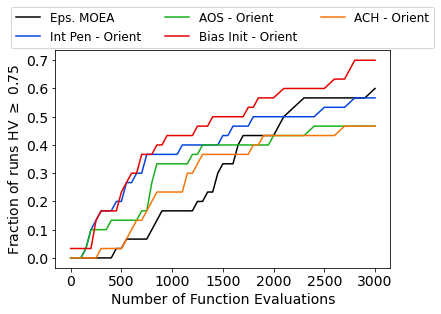

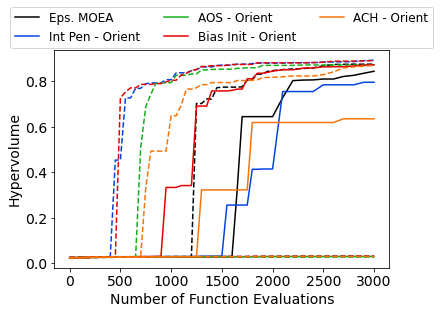

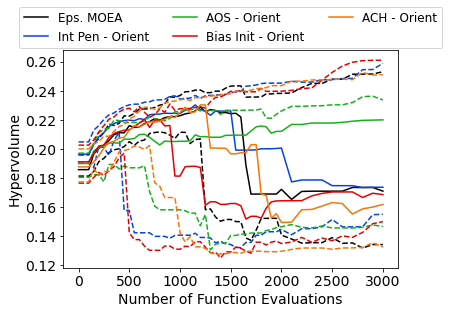

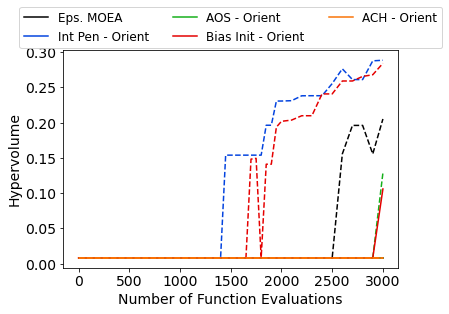

{'case0': array([0.02469012, 0.02469012, 0.02469012, 0.025527  , 0.02594944,
       0.02625969, 0.02634466, 0.026456  , 0.02660867, 0.02699312,
       0.02704324, 0.02740533, 0.02767545, 0.02796435, 0.02801464,
       0.02808276, 0.02825783, 0.02838811, 0.02845034, 0.02852965,
       0.02853545, 0.02876901, 0.02885478, 0.02892875, 0.02895835,
       0.02897495, 0.02899992, 0.02914404, 0.02928983, 0.02930473,
       0.0297428 , 0.02974853, 0.03013376, 0.31619134, 0.64409384,
       0.64409384, 0.64409384, 0.64409384, 0.64409384, 0.64409384,
       0.64409384, 0.7275057 , 0.80235517, 0.80468068, 0.80542994,
       0.80936233, 0.80936233, 0.82072274, 0.82554962, 0.83479946,
       0.84342571]), 'case1': array([0.02477886, 0.02477886, 0.02477886, 0.02565367, 0.02652303,
       0.02718912, 0.02762899, 0.02794135, 0.02797236, 0.0281842 ,
       0.02836925, 0.02862778, 0.02863582, 0.02878386, 0.02885324,
       0.02893085, 0.02893383, 0.02913821, 0.02942261, 0.02943582,
       0.02949683, 0.0

In [20]:
plotting_all_cases(nfe_cdf_array, hv_dict_med_cases, hv_dict_1q_cases, hv_dict_3q_cases, hv_dict_true_med_cases, hv_dict_true_1q_cases, hv_dict_true_3q_cases, hv_dict_truefeas_med_cases, hv_dict_truefeas_1q_cases, hv_dict_truefeas_3q_cases, nfe_array_1, line_colours, alpha_values, casenames)
print(hv_dict_med_cases)

In [ ]:
%debug

#### Variable Radii Runs

In [ ]:
#### CASE 1 - SIMPLE E-MOEA
fibre_stiffness = False
num_runs = 30 # number of runs for each case
repeat_case_read = '3x3'
optimization_prob2_bool = True # boolean to read optimization problem2 data
constant_rad_data_read = False
sidenum = 3 # 3x3 node grid
# bools = [int_pen_partcoll, AOS_partcoll, bias_init_partcoll, ACH_partcoll, int_pen_nodalprop, AOS_nodalprop, bias_init_nodalprop, ACH_nodalprop, int_pen_orient, AOS_orient, bias_init_orient, ACH_orient, fibre_stiffness]
case_bools = [False, False, False, False, False, False, False, False, False, False, False, False, fibre_stiffness]

hypervolume_computation_single_case(fibre_stiffness, case_bools, optimization_prob2_bool, constant_rad_data_read, repeat_case_read, sidenum, num_runs, 'Case1_varrad')

In [ ]:
#### Comparing Simple E-MOEA with AOS - Orientation (3000 NFE)
fibre_stiffness = False
optimization_prob2_bool = True # boolean to read optimization problem2 data
constant_rad_data_read = False # Read constant radii problem data
sidenum = 3 # 3x3 node grid
repeat_case_read = '3x3'
cases_dict = {}
num_runs = 30 # number of runs for each case

# bools = [int_pen_partcoll, AOS_partcoll, bias_init_partcoll, ACH_partcoll, int_pen_nodalprop, AOS_nodalprop, bias_init_nodalprop, ACH_nodalprop, int_pen_orient, AOS_orient, bias_init_orient, ACH_orient, bias_init_feas, AOS_feas, fibre_stiffness]
case1_bools = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, fibre_stiffness] # Simple E-MOEA
case2_bools = [False, False, False, False, False, False, False, False, False, True, False, False, True, True, fibre_stiffness] #  AOS - Orientation

cases_dict['case1'] = case1_bools
cases_dict['case2'] = case2_bools

line_colours = ['xkcd:black','xkcd:blue']
casenames = ['Without Heuristics','With Heuristics']

alpha_values = [0.5,0.5] # change based on number of cases/visibility

nfe_cdf_array, hv_dict_med_cases, hv_dict_1q_cases, hv_dict_3q_cases, hv_dict_true_med_cases, hv_dict_true_1q_cases, hv_dict_true_3q_cases, nfe_array_1 = hypervolume_computation_all_cases(fibre_stiffness, cases_dict, optimization_prob2_bool, constant_rad_data_read, repeat_case_read, sidenum, num_runs, line_colours, alpha_values, casenames)

In [ ]:
plotting_all_cases(nfe_cdf_array, hv_dict_med_cases, hv_dict_1q_cases, hv_dict_3q_cases, hv_dict_true_med_cases, hv_dict_true_1q_cases, hv_dict_true_3q_cases, nfe_array_1, line_colours, alpha_values, casenames)

In [ ]:
%debug

In [ ]:
import numpy as np
n_iter_total = 50 # Total number of points in NFE array (1 more than input value to incorporate 0)
n_iter_init = 40 # Number of initial points in NFE array separated by 50 (the rest after that are separated by 100)
nfe_array = np.zeros(n_iter_total+1)
for i in range(n_iter_init):
    nfe_array[i] = 50*i
    
for i in range(n_iter_total - n_iter_init + 1):
    nfe_array[n_iter_init+i] = 50*n_iter_init + 100*i
    
print(nfe_array)

In [ ]:
#a = [1,2,3,4,5,6]
#b = [0,0.5,1,0.5,0.5,1]
#c = [val == 1 for val in b]
a = 10
b = [1,2,3,4]
print([i*a for i in b])